# exp006 - 「Less is More」による精密最適化（高速版）

exp005の失敗を受けて、シンプル化と効率的な最適化による改善を目指す

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

plt.rcParams['font.family'] = 'IPAexGothic'

print("🎯 exp006 - Less is More戦略（高速版）")

# データ読み込み
train_df = pd.read_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/data/train.csv')
test_df = pd.read_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/data/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

🎯 exp006 - Less is More戦略（高速版）
Train shape: (891, 12)
Test shape: (418, 11)


In [2]:
# exp004特徴量エンジニアリング（簡略版）
def create_features(df):
    df = df.copy()
    
    # 名前からの特徴量
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.')
    title_mapping = {
        'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Mrs', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    df['Title_Grouped'] = df['Title'].map(title_mapping).fillna('Other')
    
    # 苗字と家族サイズ
    df['Surname'] = df['Name'].str.split(',').str[0]
    all_surnames = pd.concat([train_df['Name'], test_df['Name']]).str.split(',').str[0]
    surname_counts = all_surnames.value_counts()
    df['Surname_Count'] = df['Surname'].map(surname_counts)
    
    # チケット・客室特徴量
    df['Ticket_IsNumeric'] = df['Ticket'].str.isnumeric().astype(int)
    all_tickets = pd.concat([train_df['Ticket'], test_df['Ticket']])
    ticket_counts = all_tickets.value_counts()
    df['Ticket_Count'] = df['Ticket'].map(ticket_counts)
    
    df['HasCabin'] = (~df['Cabin'].isnull()).astype(int)
    
    # 基本前処理
    df['Sex_Binary'] = df['Sex'].map({'female': 0, 'male': 1})
    df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # 家族構成
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # 交互作用
    df['Sex_Pclass'] = df['Sex_Binary'] * df['Pclass']
    df['Age_Fare_Interaction'] = df['Age'] * df['Fare']
    
    # 統計特徴量
    df['Age_Rank_SexPclass'] = df.groupby(['Sex_Binary', 'Pclass'])['Age'].rank(pct=True)
    df['Fare_Rank_Pclass'] = df.groupby('Pclass')['Fare'].rank(pct=True)
    
    return df

# 特徴量作成
train_processed = create_features(train_df)
test_processed = create_features(test_df)

# カテゴリカルエンコーディング
for feature in ['Embarked', 'Title_Grouped']:
    le = LabelEncoder()
    all_categories = pd.concat([train_processed[feature], test_processed[feature]]).astype(str)
    le.fit(all_categories)
    
    train_processed[feature] = le.transform(train_processed[feature].astype(str))
    test_processed[feature] = le.transform(test_processed[feature].astype(str))

print("特徴量エンジニアリング完了")

特徴量エンジニアリング完了


In [3]:
# 重要度ベース特徴量選択
exclude_features = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived', 'Surname', 'Title', 'Sex']
candidate_features = [col for col in train_processed.columns 
                     if col not in exclude_features and 
                     train_processed[col].dtype in ['int64', 'float64', 'int32', 'float32']]

X_full = train_processed[candidate_features]
y = train_processed['Survived']
X_test_full = test_processed[candidate_features]

print(f"候補特徴量: {len(candidate_features)}個")

# 重要度取得（簡易版）
lgb_simple = lgb.LGBMClassifier(random_state=42, verbose=-1, n_estimators=100)
lgb_simple.fit(X_full, y)
importance_scores = lgb_simple.feature_importances_

importance_df = pd.DataFrame({
    'feature': candidate_features,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

print("\n重要度ランキング:")
for i, row in importance_df.head(15).iterrows():
    print(f"{importance_df.index.get_loc(i)+1:2d}. {row['feature']:20s}: {row['importance']:8.4f}")

# 最適特徴量セット決定（重要度上位15個）
optimal_features = importance_df.head(15)['feature'].tolist()
print(f"\n選択特徴量: {len(optimal_features)}個")

X_optimal = X_full[optimal_features]
X_test_optimal = X_test_full[optimal_features]

候補特徴量: 18個



重要度ランキング:
 1. Age_Fare_Interaction: 561.0000
 2. Age_Rank_SexPclass  : 484.0000
 3. Fare_Rank_Pclass    : 478.0000
 4. Fare                : 374.0000
 5. Age                 : 365.0000
 6. Surname_Count       : 143.0000
 7. Title_Grouped       :  77.0000
 8. Ticket_IsNumeric    :  76.0000
 9. Ticket_Count        :  76.0000
10. Embarked            :  66.0000
11. FamilySize          :  63.0000
12. Sex_Binary          :  58.0000
13. SibSp               :  51.0000
14. Pclass              :  45.0000
15. HasCabin            :  42.0000

選択特徴量: 15個


In [4]:
# 軽量Optuna最適化
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'random_state': 42,
        'n_estimators': 200,  # 高速化のため削減
        
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    
    # 3-fold CV（高速化）
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in kf.split(X_optimal, y):
        X_train, X_val = X_optimal.iloc[train_idx], X_optimal.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                 callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
        
        val_pred = model.predict(X_val)
        fold_score = accuracy_score(y_val, val_pred)
        cv_scores.append(fold_score)
    
    return np.mean(cv_scores)

print("\nOptuna最適化開始（30回試行）...")
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f"\n最高CV精度: {study.best_value:.4f}")
print("最適パラメータ:")
for param, value in study.best_params.items():
    print(f"{param:20s}: {value}")

best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'random_state': 42
})

[I 2025-08-26 15:30:25,207] A new study created in memory with name: no-name-f4ab54c6-5e42-4aad-9311-5237033e1f66



Optuna最適化開始（30回試行）...


  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.376761
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.413316
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.378139
[I 2025-08-26 15:30:26,024] Trial 0 finished with value: 0.8529741863075196 and parameters: {'num_leaves': 28, 'learning_rate': 0.14507143064099162, 'feature_fraction': 0.8927975767245621, 'bagging_fraction': 0.8394633936788146, 'reg_alpha': 0.15601864044243652, 'reg_lambda': 0.15599452033620265}. Best is trial 0 with value: 0.8529741863075196.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.370413
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.417518
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.382178
[I 2025-08-26 15:30:26,725] Trial 1 finished with value: 0.8529741863075196 and parameters: {'num_leaves': 17, 'learning_rate': 0.13661761457749352, 'feature_fraction': 0.8404460046972835, 'bagging_fraction': 0.8832290311184182, 'reg_alpha': 0.020584494295802447, 'reg_lambda': 0.9699098521619943}. Best is trial 0 with value: 0.8529741863075196.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.378024
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.409573
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.387135
[I 2025-08-26 15:30:27,741] Trial 2 finished with value: 0.850729517396184 and parameters: {'num_leaves': 44, 'learning_rate': 0.07123391106782762, 'feature_fraction': 0.6727299868828402, 'bagging_fraction': 0.6733618039413735, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 0 with value: 0.8529741863075196.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.37786
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.417392
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.384334
[I 2025-08-26 15:30:28,704] Trial 3 finished with value: 0.8451178451178452 and parameters: {'num_leaves': 30, 'learning_rate': 0.07912291401980419, 'feature_fraction': 0.8447411578889518, 'bagging_fraction': 0.6557975442608167, 'reg_alpha': 0.29214464853521815, 'reg_lambda': 0.3663618432936917}. Best is trial 0 with value: 0.8529741863075196.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.379989
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.412379
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.385549
[I 2025-08-26 15:30:29,495] Trial 4 finished with value: 0.8484848484848485 and parameters: {'num_leaves': 31, 'learning_rate': 0.12851759613930136, 'feature_fraction': 0.6798695128633439, 'bagging_fraction': 0.8056937753654446, 'reg_alpha': 0.5924145688620425, 'reg_lambda': 0.046450412719997725}. Best is trial 0 with value: 0.8529741863075196.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.378504
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.412392
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.386036
[I 2025-08-26 15:30:30,642] Trial 5 finished with value: 0.8439955106621774 and parameters: {'num_leaves': 36, 'learning_rate': 0.06705241236872915, 'feature_fraction': 0.6260206371941118, 'bagging_fraction': 0.9795542149013333, 'reg_alpha': 0.9656320330745594, 'reg_lambda': 0.8083973481164611}. Best is trial 0 with value: 0.8529741863075196.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.377392
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.4153
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.38583
[I 2025-08-26 15:30:31,750] Trial 6 finished with value: 0.8484848484848485 and parameters: {'num_leaves': 25, 'learning_rate': 0.05976721140063839, 'feature_fraction': 0.8736932106048627, 'bagging_fraction': 0.7760609974958405, 'reg_alpha': 0.12203823484477883, 'reg_lambda': 0.4951769101112702}. Best is trial 0 with value: 0.8529741863075196.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.369772
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.411654
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.384528
[I 2025-08-26 15:30:32,384] Trial 7 finished with value: 0.8484848484848485 and parameters: {'num_leaves': 16, 'learning_rate': 0.1409320402078782, 'feature_fraction': 0.7035119926400067, 'bagging_fraction': 0.8650089137415928, 'reg_alpha': 0.31171107608941095, 'reg_lambda': 0.5200680211778108}. Best is trial 0 with value: 0.8529741863075196.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.37454
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.411904
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.390952
[I 2025-08-26 15:30:33,347] Trial 8 finished with value: 0.8518518518518517 and parameters: {'num_leaves': 34, 'learning_rate': 0.0684854455525527, 'feature_fraction': 0.9878338511058234, 'bagging_fraction': 0.9100531293444458, 'reg_alpha': 0.9394989415641891, 'reg_lambda': 0.8948273504276488}. Best is trial 0 with value: 0.8529741863075196.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.380093
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.416044
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.386575
[I 2025-08-26 15:30:34,162] Trial 9 finished with value: 0.8540965207631874 and parameters: {'num_leaves': 36, 'learning_rate': 0.14218742350231167, 'feature_fraction': 0.6353970008207678, 'bagging_fraction': 0.678393144967658, 'reg_alpha': 0.045227288910538066, 'reg_lambda': 0.32533033076326434}. Best is trial 9 with value: 0.8540965207631874.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.376537
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.414276
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.383149
[I 2025-08-26 15:30:34,993] Trial 10 finished with value: 0.8439955106621774 and parameters: {'num_leaves': 49, 'learning_rate': 0.10659360709459065, 'feature_fraction': 0.747491509088439, 'bagging_fraction': 0.6071847502459278, 'reg_alpha': 0.6370920485539681, 'reg_lambda': 0.2894610629307977}. Best is trial 9 with value: 0.8540965207631874.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.377691
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.421906
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.382441
[I 2025-08-26 15:30:35,861] Trial 11 finished with value: 0.8473625140291806 and parameters: {'num_leaves': 41, 'learning_rate': 0.1164123014250405, 'feature_fraction': 0.9323829954957575, 'bagging_fraction': 0.7518416973680894, 'reg_alpha': 0.009571433056508032, 'reg_lambda': 0.03465711726739068}. Best is trial 9 with value: 0.8540965207631874.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.376418
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.408248
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.382592
[I 2025-08-26 15:30:36,640] Trial 12 finished with value: 0.8484848484848485 and parameters: {'num_leaves': 25, 'learning_rate': 0.149502869582801, 'feature_fraction': 0.7766056506575825, 'bagging_fraction': 0.7209121549636469, 'reg_alpha': 0.18904273771151736, 'reg_lambda': 0.21785358383633718}. Best is trial 9 with value: 0.8540965207631874.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.377384
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.417686
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.385129
[I 2025-08-26 15:30:37,534] Trial 13 finished with value: 0.8518518518518517 and parameters: {'num_leaves': 25, 'learning_rate': 0.09099397786361343, 'feature_fraction': 0.9158816975290052, 'bagging_fraction': 0.8111115572120128, 'reg_alpha': 0.46870521888784217, 'reg_lambda': 0.1288706766978636}. Best is trial 9 with value: 0.8540965207631874.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.377478
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.419932
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.383411
[I 2025-08-26 15:30:38,435] Trial 14 finished with value: 0.850729517396184 and parameters: {'num_leaves': 40, 'learning_rate': 0.12006440447024752, 'feature_fraction': 0.6023553657214022, 'bagging_fraction': 0.6908556046603515, 'reg_alpha': 0.16411760093954242, 'reg_lambda': 0.3516465433767437}. Best is trial 9 with value: 0.8540965207631874.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.380122
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.412022
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.384174
[I 2025-08-26 15:30:39,201] Trial 15 finished with value: 0.8496071829405163 and parameters: {'num_leaves': 29, 'learning_rate': 0.1473391102890388, 'feature_fraction': 0.7987586652315627, 'bagging_fraction': 0.8431153824350242, 'reg_alpha': 0.40095596968204394, 'reg_lambda': 0.6855046081289344}. Best is trial 9 with value: 0.8540965207631874.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.374638
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.410316
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.376958
[I 2025-08-26 15:30:39,975] Trial 16 finished with value: 0.8417508417508417 and parameters: {'num_leaves': 20, 'learning_rate': 0.1296939645858437, 'feature_fraction': 0.9664730977011131, 'bagging_fraction': 0.9349418029162155, 'reg_alpha': 0.7777116035069408, 'reg_lambda': 0.19867706922050493}. Best is trial 9 with value: 0.8540965207631874.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.380113
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.415897
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.384354
[I 2025-08-26 15:30:40,907] Trial 17 finished with value: 0.8496071829405163 and parameters: {'num_leaves': 38, 'learning_rate': 0.1018056100605875, 'feature_fraction': 0.7333306877482294, 'bagging_fraction': 0.6112835058552188, 'reg_alpha': 0.08419622745238281, 'reg_lambda': 0.41912937173413833}. Best is trial 9 with value: 0.8540965207631874.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.377283
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.416522
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.383421
[I 2025-08-26 15:30:41,729] Trial 18 finished with value: 0.8507295173961841 and parameters: {'num_leaves': 48, 'learning_rate': 0.11440755919849299, 'feature_fraction': 0.8841749575369519, 'bagging_fraction': 0.7397562484304057, 'reg_alpha': 0.278051169696999, 'reg_lambda': 0.6423620561394953}. Best is trial 9 with value: 0.8540965207631874.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.379767
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.416193
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.377764
[I 2025-08-26 15:30:42,601] Trial 19 finished with value: 0.8552188552188552 and parameters: {'num_leaves': 21, 'learning_rate': 0.09170147349231994, 'feature_fraction': 0.8160592908860137, 'bagging_fraction': 0.8406819386071084, 'reg_alpha': 0.18609648721291477, 'reg_lambda': 0.13935442587414082}. Best is trial 19 with value: 0.8552188552188552.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.379315
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.410073
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.381087
[I 2025-08-26 15:30:43,503] Trial 20 finished with value: 0.8507295173961841 and parameters: {'num_leaves': 21, 'learning_rate': 0.08887691947863863, 'feature_fraction': 0.8210948941947224, 'bagging_fraction': 0.9778886349758447, 'reg_alpha': 0.4362061710370349, 'reg_lambda': 0.2800639060734296}. Best is trial 19 with value: 0.8552188552188552.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.379035
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.417209
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.37974
[I 2025-08-26 15:30:44,452] Trial 21 finished with value: 0.8484848484848485 and parameters: {'num_leaves': 22, 'learning_rate': 0.08813770446154914, 'feature_fraction': 0.774439933428912, 'bagging_fraction': 0.8333744933578412, 'reg_alpha': 0.19503980610224644, 'reg_lambda': 0.15211357716944696}. Best is trial 19 with value: 0.8552188552188552.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.383426
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.422972
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.382067
[I 2025-08-26 15:30:45,299] Trial 22 finished with value: 0.8496071829405163 and parameters: {'num_leaves': 28, 'learning_rate': 0.1295867761893573, 'feature_fraction': 0.8752408504325483, 'bagging_fraction': 0.7825233164332502, 'reg_alpha': 0.08367015107088982, 'reg_lambda': 0.09817031464901499}. Best is trial 19 with value: 0.8552188552188552.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.380796
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.413722
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.38442
[I 2025-08-26 15:30:46,098] Trial 23 finished with value: 0.850729517396184 and parameters: {'num_leaves': 34, 'learning_rate': 0.13862515516740193, 'feature_fraction': 0.9288202724255707, 'bagging_fraction': 0.8985841076719503, 'reg_alpha': 0.23191829511197803, 'reg_lambda': 0.23935985632829493}. Best is trial 19 with value: 0.8552188552188552.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.374745
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.419319
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.380834
[I 2025-08-26 15:30:46,981] Trial 24 finished with value: 0.8484848484848485 and parameters: {'num_leaves': 27, 'learning_rate': 0.10815352366745576, 'feature_fraction': 0.8122387609410768, 'bagging_fraction': 0.8471674449936544, 'reg_alpha': 0.018460657926128242, 'reg_lambda': 0.33504431052334105}. Best is trial 19 with value: 0.8552188552188552.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.373122
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.417629
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.382587
[I 2025-08-26 15:30:47,763] Trial 25 finished with value: 0.8552188552188552 and parameters: {'num_leaves': 18, 'learning_rate': 0.09482212932743175, 'feature_fraction': 0.9016184566274927, 'bagging_fraction': 0.7113692077761353, 'reg_alpha': 0.36801152067008186, 'reg_lambda': 0.15101457301236293}. Best is trial 19 with value: 0.8552188552188552.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.37579
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.410806
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.381534
[I 2025-08-26 15:30:48,564] Trial 26 finished with value: 0.8529741863075196 and parameters: {'num_leaves': 18, 'learning_rate': 0.09607787867077872, 'feature_fraction': 0.6468329412700768, 'bagging_fraction': 0.6452606057786048, 'reg_alpha': 0.377679814959981, 'reg_lambda': 0.012015617286114055}. Best is trial 19 with value: 0.8552188552188552.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.378489
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.414923
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.384163
[I 2025-08-26 15:30:49,646] Trial 27 finished with value: 0.8473625140291808 and parameters: {'num_leaves': 19, 'learning_rate': 0.050398962415843435, 'feature_fraction': 0.723819408991232, 'bagging_fraction': 0.7088222688961449, 'reg_alpha': 0.38164941159781374, 'reg_lambda': 0.44108277190662687}. Best is trial 19 with value: 0.8552188552188552.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.376151
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.410201
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.379971
[I 2025-08-26 15:30:50,557] Trial 28 finished with value: 0.850729517396184 and parameters: {'num_leaves': 23, 'learning_rate': 0.08180380072133389, 'feature_fraction': 0.7667596161418875, 'bagging_fraction': 0.6375992242962368, 'reg_alpha': 0.5697958154898946, 'reg_lambda': 0.08668068799272383}. Best is trial 19 with value: 0.8552188552188552.
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.371501
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.409512
Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.380132
[I 2025-08-26 15:30:51,244] Trial 29 finished with value: 0.8540965207631874 and parameters: {'num_leaves': 15, 'learning_rate': 0.09762805066121431, 'feature_fraction': 0.84837088899058, 'bagging_fraction': 0.7590883030321929, 'reg_alpha': 0.10608008328890497, 'reg_lambda': 0.18040464545305832}. Best is trial 19 with value: 0.8552188552188552.

最高CV精度: 0.8552
最適パラメータ:
num_leaves          : 21
learning_rate       : 0.09170147349231994
feature_fraction    : 0.8160592908860137
bagging_fraction    : 0.8406819386071084
reg_alpha           : 0.18609648721291477
reg_lambda          : 0.13935442587414082



最終モデル構築中...
Training until validation scores don't improve for 100 rounds


Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.363104
Fold 1: 0.8603
Training until validation scores don't improve for 100 rounds


Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.396265
Fold 2: 0.8427
Training until validation scores don't improve for 100 rounds


Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.425934
Fold 3: 0.8258
Training until validation scores don't improve for 100 rounds


Did not meet early stopping. Best iteration is:
[29]	valid_0's binary_logloss: 0.409193
Fold 4: 0.8427
Training until validation scores don't improve for 100 rounds


Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.376813
Fold 5: 0.8483

=== 最終結果 ===
CV Accuracy: 0.8440 ± 0.0111
OOF Accuracy: 0.8440

=== exp004との比較 ===
exp004 CV: 0.8462
exp006 CV: 0.8440 (-0.0022)

期待Kaggle: 0.77785
exp004から: -0.00205 (-0.26%)
⚠️ 改善は限定的

=== 最終特徴量重要度 ===
 1. Age_Fare_Interaction: 135.6000
 2. Age_Rank_SexPclass  : 112.2000
 3. Fare                :  97.2000
 4. Fare_Rank_Pclass    :  90.8000
 5. Age                 :  80.2000
 6. Sex_Binary          :  29.8000
 7. Title_Grouped       :  27.4000
 8. Pclass              :  25.6000
 9. Surname_Count       :  23.2000
10. Ticket_Count        :  22.4000
11. FamilySize          :  19.8000
12. Embarked            :  14.0000
13. HasCabin            :  12.0000
14. SibSp               :  10.6000
15. Ticket_IsNumeric    :   4.2000


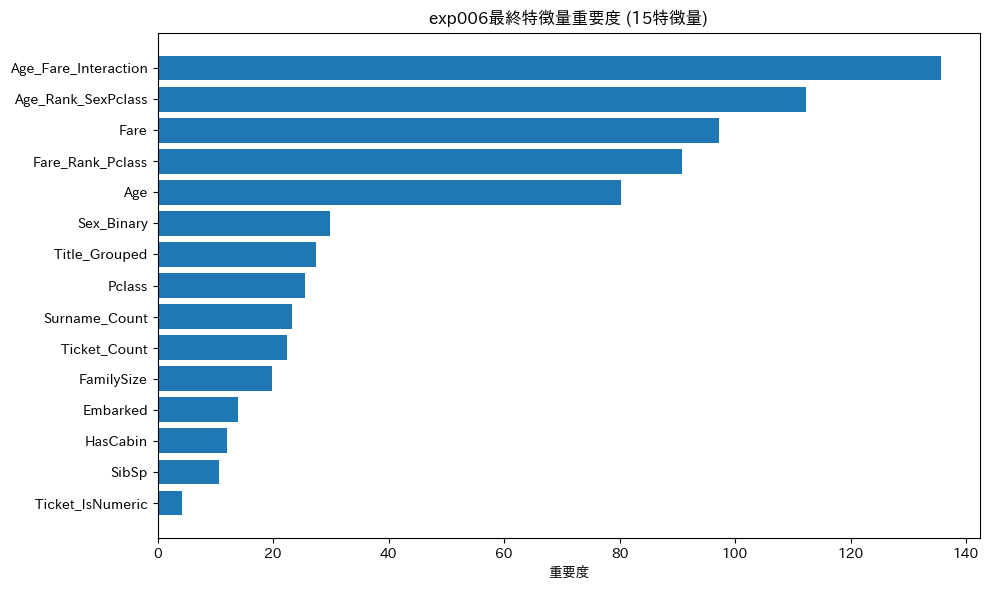

In [5]:
# 最終モデル構築
print("\n最終モデル構築中...")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_cv_scores = []
oof_predictions = np.zeros(len(X_optimal))
test_predictions = np.zeros(len(X_test_optimal))
feature_importance_final = np.zeros(len(optimal_features))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_optimal, y), 1):
    X_train, X_val = X_optimal.iloc[train_idx], X_optimal.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = lgb.LGBMClassifier(**best_params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
             callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])
    
    # 予測
    val_pred_proba = model.predict_proba(X_val)[:, 1]
    val_pred = model.predict(X_val)
    test_pred_proba = model.predict_proba(X_test_optimal)[:, 1]
    
    fold_score = accuracy_score(y_val, val_pred)
    final_cv_scores.append(fold_score)
    
    oof_predictions[val_idx] = val_pred_proba
    test_predictions += test_pred_proba / 5
    feature_importance_final += model.feature_importances_
    
    print(f"Fold {fold}: {fold_score:.4f}")

final_cv_mean = np.mean(final_cv_scores)
final_cv_std = np.std(final_cv_scores)
oof_accuracy = accuracy_score(y, (oof_predictions >= 0.5).astype(int))
feature_importance_final /= 5

print(f"\n=== 最終結果 ===")
print(f"CV Accuracy: {final_cv_mean:.4f} ± {final_cv_std:.4f}")
print(f"OOF Accuracy: {oof_accuracy:.4f}")

# exp004との比較
exp004_cv = 0.8462
exp004_kaggle = 0.77990
cv_improvement = final_cv_mean - exp004_cv
expected_kaggle = final_cv_mean * (exp004_kaggle / exp004_cv)
kaggle_improvement = expected_kaggle - exp004_kaggle

print(f"\n=== exp004との比較 ===")
print(f"exp004 CV: {exp004_cv:.4f}")
print(f"exp006 CV: {final_cv_mean:.4f} ({cv_improvement:+.4f})")
print(f"\n期待Kaggle: {expected_kaggle:.5f}")
print(f"exp004から: {kaggle_improvement:+.5f} ({kaggle_improvement/exp004_kaggle*100:+.2f}%)")

if kaggle_improvement > 0.005:
    print("🎉 大幅改善が期待される！")
elif kaggle_improvement > 0:
    print("✅ 改善が期待される")
else:
    print("⚠️ 改善は限定的")

# 最終特徴量重要度
final_importance_df = pd.DataFrame({
    'feature': optimal_features,
    'importance': feature_importance_final
}).sort_values('importance', ascending=False)

print(f"\n=== 最終特徴量重要度 ===")
for i, row in final_importance_df.iterrows():
    print(f"{final_importance_df.index.get_loc(i)+1:2d}. {row['feature']:20s}: {row['importance']:8.4f}")

# 可視化
plt.figure(figsize=(10, 6))
plt.barh(range(len(final_importance_df)), final_importance_df['importance'])
plt.yticks(range(len(final_importance_df)), final_importance_df['feature'])
plt.xlabel('重要度')
plt.title(f'exp006最終特徴量重要度 ({len(optimal_features)}特徴量)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [6]:
# 提出ファイル生成
test_predictions_binary = (test_predictions >= 0.5).astype(int)

submission = pd.DataFrame({
    'PassengerId': test_processed['PassengerId'],
    'Survived': test_predictions_binary
})

submission.to_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/results/exp006/result.csv', index=False)

print(f"\n=== 提出ファイル生成完了 ===")
print(f"生存予測数: {test_predictions_binary.sum()}")
print(f"死亡予測数: {len(test_predictions_binary) - test_predictions_binary.sum()}")
print(f"予測生存率: {test_predictions_binary.mean():.3f}")
print(f"実際生存率: {y.mean():.3f}")
print(f"\n💾 提出ファイル保存: results/exp006/result.csv")

print("\n" + "="*60)
print("                🎯 EXP006 完了")
print("="*60)
print(f"戦略: Less is More（{len(optimal_features)}特徴量）")
print(f"CV性能: {final_cv_mean:.4f} ± {final_cv_std:.4f}")
print(f"期待改善: {kaggle_improvement:+.5f}")
print("Kaggleでの結果をお楽しみに！")
print("="*60)


=== 提出ファイル生成完了 ===
生存予測数: 137
死亡予測数: 281
予測生存率: 0.328
実際生存率: 0.384

💾 提出ファイル保存: results/exp006/result.csv

                🎯 EXP006 完了
戦略: Less is More（15特徴量）
CV性能: 0.8440 ± 0.0111
期待改善: -0.00205
Kaggleでの結果をお楽しみに！
